<a href="https://colab.research.google.com/github/arrozepaum/app/blob/main/Identifica%C3%A7%C3%A3o_de_Emo%C3%A7%C3%A3o_e_Transcri%C3%A7%C3%A3o_de_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificação de Emoção e Transcrição de Audio


# Importando as bibliotecas

In [ ]:
!pip install librosa==0.8.1
!pip install SpeechRecognition==3.8.1
!pip install PyAudio
!pip install --upgrade --no-cache-dir gdown


  Using cached PyAudio-0.2.14.tar.gz (47 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for PyAudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyAudio
Failed to build PyAudio
ERROR: Could not build wheels for PyAudio, which is required to install pyproject.toml-based projects


In [ ]:
import os
import pathlib
from datetime import datetime
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import speech_recognition as sr
import soundfile as sf
from IPython.display import Audio, Javascript
from google.colab import output
from io import BytesIO
from base64 import b64decode
from pydub import AudioSegment
import sys
sns.set()


In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip -O Audio_Song_Actors_01-24.zip
!unzip Audio_Song_Actors_01-24.zip -d '/content/Audio_Song_Actors'
!rm Audio_Song_Actors_01-24.zip

--2024-01-21 22:43:27--  https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Song_Actors_01-24.zip [following]
--2024-01-21 22:43:28--  https://zenodo.org/records/1188976/files/Audio_Song_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 225505317 (215M) [application/octet-stream]
Saving to: ‘Audio_Song_Actors_01-24.zip’

Audio_Song_Actors_0 100%[===================>] 215.06M  18.1MB/s    in 14s     

2024-01-21 22:43:43 (15.1 MB/s) - ‘Audio_Song_Actors_01-24.zip’ saved [225505317/225505317]

Archive:  Audio_Song_Actors_01-24.zip
   creating: /content/Audio_Song_Actors/Actor_01/
  inflating: /content/Audio_Song_Actors/Actor_01/03-02-01-01-01-01

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O Audio_Speech_Actors_01-24.zip
!unzip Audio_Speech_Actors_01-24.zip -d '/content/Audio_Speech_Actors'
!rm Audio_Speech_Actors_01-24.zip

--2024-01-21 22:43:51--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2024-01-21 22:43:52--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  18.3MB/s    in 13s     

2024-01-21 22:44:05 (15.1 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

Archive:  Audio_Speech_Actors_01-24.zip
   creating: /content/Audio_Speech_Actors/Actor_01/
  inflating: /content/Audio_Speech_Actors/Actor_01/0

In [ ]:
url = 'https://drive.google.com/file/d/1_U85NkK1DDEeKLOE36mSkds_kgdGrokI/view?usp=sharing'
output = '/content/Tess/'
gdown.download(url = url, output = output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1_U85NkK1DDEeKLOE36mSkds_kgdGrokI
From (redirected): https://drive.google.com/uc?id=1_U85NkK1DDEeKLOE36mSkds_kgdGrokI&confirm=t&uuid=b7a7b26f-101a-4e78-a5d3-f9de948733c4
To: /content/Tess/Tess.zip
100%|██████████| 224M/224M [00:02<00:00, 81.5MB/s]


'/content/Tess/Tess.zip'

In [ ]:
%cd /content/Tess/

/content/Tess


In [ ]:
!unzip Tess.zip -x "*.TXT*" -d '/content/Tess/'
!rm Tess.zip
%cd ..

Archive:  Tess.zip
  inflating: /content/Tess/OAF_back_angry.wav  
  inflating: /content/Tess/OAF_back_disgust.wav  
  inflating: /content/Tess/OAF_back_fear.wav  
  inflating: /content/Tess/OAF_back_happy.wav  
  inflating: /content/Tess/OAF_back_neutral.wav  
  inflating: /content/Tess/OAF_back_ps.wav  
  inflating: /content/Tess/OAF_back_sad.wav  
  inflating: /content/Tess/OAF_bar_angry.wav  
  inflating: /content/Tess/OAF_bar_disgust.wav  
  inflating: /content/Tess/OAF_bar_fear.wav  
  inflating: /content/Tess/OAF_bar_happy.wav  
  inflating: /content/Tess/OAF_bar_neutral.wav  
  inflating: /content/Tess/OAF_bar_ps.wav  
  inflating: /content/Tess/OAF_bar_sad.wav  
  inflating: /content/Tess/OAF_base_angry.wav  
  inflating: /content/Tess/OAF_base_disgust.wav  
  inflating: /content/Tess/OAF_base_fear.wav  
  inflating: /content/Tess/OAF_base_happy.wav  
  inflating: /content/Tess/OAF_base_neutral.wav  
  inflating: /content/Tess/OAF_base_ps.wav  
  inflating: /content/Tess/OAF_b

## Setando os Dados


In [ ]:
modalitys = []
voc_channels = []
emotions = []
intensitys = []
phrases =[]
actors = []

full_path = []

def create_dataset(DATASET):
  for root, dirs, files in tqdm(os.walk(DATASET)):
      for file in files:
          try:
              modal = int(file[1:2])
              vchan = int(file[4:5])
              label = int(file[7:8])
              ints = int(file[10:11])
              phr = int(file[13:14])
              act = int(file[19:20])

              modalitys.append(modal)
              voc_channels.append(vchan)
              emotions.append(label)
              intensitys.append(ints)
              phrases.append(phr)
              actors.append(act)

              full_path.append((root, file))

          except ValueError:
              continue

In [ ]:
create_dataset('/content/Audio_Speech_Actors')
create_dataset('/content/Audio_Song_Actors')

25it [00:00, 4607.71it/s]
25it [00:00, 5014.95it/s]


In [ ]:
emotions_list = ['neutra', 'calma', 'feliz', 'triste', 'nervosa', 'medo', 'nojo', 'surpreso']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}
emotion_dict

{1: 'neutra',
 2: 'calma',
 3: 'feliz',
 4: 'triste',
 5: 'nervosa',
 6: 'medo',
 7: 'nojo',
 8: 'surpreso'}

In [ ]:
RAVDESS_df = pd.DataFrame([emotions, voc_channels, modalitys, intensitys, actors, phrases, full_path]).T

In [ ]:
RAVDESS_df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
RAVDESS_df['emotion'] = RAVDESS_df['emotion'].map(emotion_dict)
RAVDESS_df['voc_channel'] = RAVDESS_df['voc_channel'].map({1: 'fala', 2:'musica'})
RAVDESS_df['modality'] = RAVDESS_df['modality'].map({1: 'AV completo', 2:'apenas video', 3:'apenas audio'})
RAVDESS_df['intensity'] = RAVDESS_df['intensity'].map({1: 'normal', 2:'forte'})
RAVDESS_df['actors'] = RAVDESS_df['actors'].apply(lambda x: 'feminino' if x%2 == 0 else 'masculino')
RAVDESS_df['phrase'] = RAVDESS_df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
RAVDESS_df['path'] = RAVDESS_df['path'].apply(lambda x: x[0] + '/' + x[1])
RAVDESS_df

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,feliz,fala,apenas audio,forte,masculino,Dogs are sitting by the door,/content/Audio_Speech_Actors/Actor_09/03-01-03...
1,nervosa,fala,apenas audio,normal,masculino,Dogs are sitting by the door,/content/Audio_Speech_Actors/Actor_09/03-01-05...
2,triste,fala,apenas audio,forte,masculino,Kids are talking by the door,/content/Audio_Speech_Actors/Actor_09/03-01-04...
3,calma,fala,apenas audio,normal,masculino,Kids are talking by the door,/content/Audio_Speech_Actors/Actor_09/03-01-02...
4,nervosa,fala,apenas audio,normal,masculino,Dogs are sitting by the door,/content/Audio_Speech_Actors/Actor_09/03-01-05...
...,...,...,...,...,...,...,...
2447,triste,musica,apenas audio,normal,masculino,Dogs are sitting by the door,/content/Audio_Song_Actors/Actor_03/03-02-04-0...
2448,triste,musica,apenas audio,forte,masculino,Dogs are sitting by the door,/content/Audio_Song_Actors/Actor_03/03-02-04-0...
2449,calma,musica,apenas audio,forte,masculino,Dogs are sitting by the door,/content/Audio_Song_Actors/Actor_03/03-02-02-0...
2450,neutra,musica,apenas audio,normal,masculino,Kids are talking by the door,/content/Audio_Song_Actors/Actor_03/03-02-01-0...


## Distribuição


In [ ]:
RAVDESS_df.emotion.value_counts()

feliz       376
nervosa     376
triste      376
calma       376
medo        376
nojo        192
surpreso    192
neutra      188
Name: emotion, dtype: int64

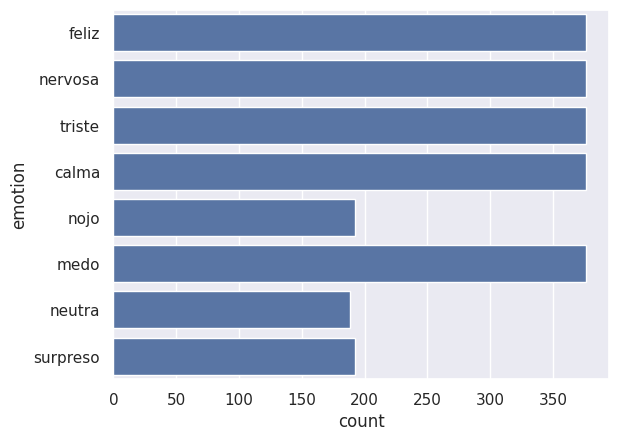

In [ ]:
sns.countplot(RAVDESS_df.emotion);

# Dados Tess

In [ ]:
dir_list = os.listdir('/content/Tess')
dir_list.sort()
print(dir_list)

['OAF_back_angry.wav', 'OAF_back_disgust.wav', 'OAF_back_fear.wav', 'OAF_back_happy.wav', 'OAF_back_neutral.wav', 'OAF_back_ps.wav', 'OAF_back_sad.wav', 'OAF_bar_angry.wav', 'OAF_bar_disgust.wav', 'OAF_bar_fear.wav', 'OAF_bar_happy.wav', 'OAF_bar_neutral.wav', 'OAF_bar_ps.wav', 'OAF_bar_sad.wav', 'OAF_base_angry.wav', 'OAF_base_disgust.wav', 'OAF_base_fear.wav', 'OAF_base_happy.wav', 'OAF_base_neutral.wav', 'OAF_base_ps.wav', 'OAF_base_sad.wav', 'OAF_bath_angry.wav', 'OAF_bath_disgust.wav', 'OAF_bath_fear.wav', 'OAF_bath_happy.wav', 'OAF_bath_neutral.wav', 'OAF_bath_ps.wav', 'OAF_bath_sad.wav', 'OAF_bean_angry.wav', 'OAF_bean_disgust.wav', 'OAF_bean_fear.wav', 'OAF_bean_happy.wav', 'OAF_bean_neutral.wav', 'OAF_bean_ps.wav', 'OAF_bean_sad.wav', 'OAF_beg_angry.wav', 'OAF_beg_disgust.wav', 'OAF_beg_fear.wav', 'OAF_beg_happy.wav', 'OAF_beg_neutral.wav', 'OAF_beg_ps.wav', 'OAF_beg_sad.wav', 'OAF_bite_angry.wav', 'OAF_bite_disgust.wav', 'OAF_bite_fear.wav', 'OAF_bite_happy.wav', 'OAF_bite_ne

In [ ]:
path = []
emotion = []

for i in dir_list:
  if 'angry' in i:
    emotion.append('nervosa')
  if 'disgust' in i:
    emotion.append('nojo')
  if 'fear' in i:
    emotion.append('medo')
  if 'happy' in i:
    emotion.append('feliz')
  if 'neutral' in i:
    emotion.append('neutra')
  if 'ps' in i:
    emotion.append('surpreso')
  if 'sad' in i:
    emotion.append('triste')
  path.append('/content/Tess/' + i)

In [ ]:
print(path)
print(emotion)

['/content/Tess/OAF_back_angry.wav', '/content/Tess/OAF_back_disgust.wav', '/content/Tess/OAF_back_fear.wav', '/content/Tess/OAF_back_happy.wav', '/content/Tess/OAF_back_neutral.wav', '/content/Tess/OAF_back_ps.wav', '/content/Tess/OAF_back_sad.wav', '/content/Tess/OAF_bar_angry.wav', '/content/Tess/OAF_bar_disgust.wav', '/content/Tess/OAF_bar_fear.wav', '/content/Tess/OAF_bar_happy.wav', '/content/Tess/OAF_bar_neutral.wav', '/content/Tess/OAF_bar_ps.wav', '/content/Tess/OAF_bar_sad.wav', '/content/Tess/OAF_base_angry.wav', '/content/Tess/OAF_base_disgust.wav', '/content/Tess/OAF_base_fear.wav', '/content/Tess/OAF_base_happy.wav', '/content/Tess/OAF_base_neutral.wav', '/content/Tess/OAF_base_ps.wav', '/content/Tess/OAF_base_sad.wav', '/content/Tess/OAF_bath_angry.wav', '/content/Tess/OAF_bath_disgust.wav', '/content/Tess/OAF_bath_fear.wav', '/content/Tess/OAF_bath_happy.wav', '/content/Tess/OAF_bath_neutral.wav', '/content/Tess/OAF_bath_ps.wav', '/content/Tess/OAF_bath_sad.wav', '/cont

In [ ]:
TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df['source'] = 'TESS'
TESS_df['actors'] = 'feminino'

TESS_df = pd.concat([TESS_df, pd.DataFrame(path, columns=['path'])], axis=1)
TESS_df

,emotion_label,source,actors,path
0,nervosa,TESS,feminino,/content/Tess/OAF_back_angry.wav
1,nojo,TESS,feminino,/content/Tess/OAF_back_disgust.wav
2,medo,TESS,feminino,/content/Tess/OAF_back_fear.wav
3,feliz,TESS,feminino,/content/Tess/OAF_back_happy.wav
4,neutra,TESS,feminino,/content/Tess/OAF_back_neutral.wav
...,...,...,...,...
2795,medo,TESS,feminino,/content/Tess/YAF_youth_fear.wav
2796,feliz,TESS,feminino,/content/Tess/YAF_youth_happy.wav
2797,neutra,TESS,feminino,/content/Tess/YAF_youth_neutral.wav
2798,surpreso,TESS,feminino,/content/Tess/YAF_youth_ps.wav


##distribuição TESS

In [ ]:
TESS_df['emotion_label'].value_counts()

nervosa     400
nojo        400
medo        400
feliz       400
neutra      400
surpreso    400
triste      400
Name: emotion_label, dtype: int64

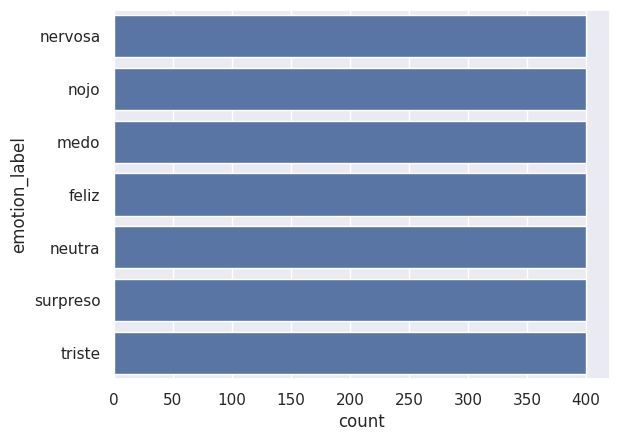

In [ ]:
sns.countplot(TESS_df['emotion_label']);

## Juntando as bases de dados

In [ ]:
RAVDESS_df.columns

Index(['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase',
       'path'],
      dtype='object')

In [ ]:
RAV_df = RAVDESS_df.copy()
RAV_df.insert(0, 'emotion_label', RAV_df['emotion'], True)
RAV_df.insert(1, 'source', 'RAV', True)
RAV_df = RAV_df.drop(columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], axis = 1)
RAV_df

,emotion_label,source,actors,path
0,feliz,RAV,masculino,/content/Audio_Speech_Actors/Actor_09/03-01-03...
1,nervosa,RAV,masculino,/content/Audio_Speech_Actors/Actor_09/03-01-05...
2,triste,RAV,masculino,/content/Audio_Speech_Actors/Actor_09/03-01-04...
3,calma,RAV,masculino,/content/Audio_Speech_Actors/Actor_09/03-01-02...
4,nervosa,RAV,masculino,/content/Audio_Speech_Actors/Actor_09/03-01-05...
...,...,...,...,...
2447,triste,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-04-0...
2448,triste,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-04-0...
2449,calma,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-02-0...
2450,neutra,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-01-0...


In [ ]:
df_combined = pd.concat([TESS_df, RAV_df])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5252 entries, 0 to 2451
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  5252 non-null   object
 1   source         5252 non-null   object
 2   actors         5252 non-null   object
 3   path           5252 non-null   object
dtypes: object(4)
memory usage: 205.2+ KB


In [ ]:
df_combined

,emotion_label,source,actors,path
0,nervosa,TESS,feminino,/content/Tess/OAF_back_angry.wav
1,nojo,TESS,feminino,/content/Tess/OAF_back_disgust.wav
2,medo,TESS,feminino,/content/Tess/OAF_back_fear.wav
3,feliz,TESS,feminino,/content/Tess/OAF_back_happy.wav
4,neutra,TESS,feminino,/content/Tess/OAF_back_neutral.wav
...,...,...,...,...
2447,triste,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-04-0...
2448,triste,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-04-0...
2449,calma,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-02-0...
2450,neutra,RAV,masculino,/content/Audio_Song_Actors/Actor_03/03-02-01-0...


In [ ]:
df_combined['emotion_label'].value_counts()

nervosa     776
medo        776
feliz       776
triste      776
nojo        592
surpreso    592
neutra      588
calma       376
Name: emotion_label, dtype: int64

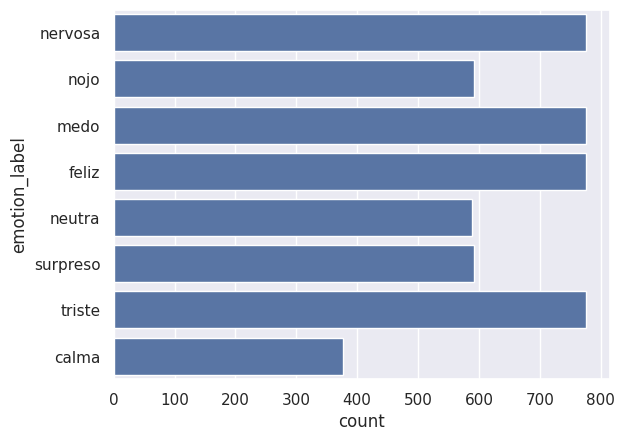

In [ ]:
sns.countplot(df_combined['emotion_label']);

# Processando os Dados



In [ ]:
def features_extractor(file_name):
    data, sample_rate = librosa.load(file_name, sr = 22050, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(df_combined.path.values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 5252/5252 [03:27<00:00, 25.30it/s]


In [ ]:
extracted_features

[[array([-3.8656073e+02,  5.7116043e+01, -2.2070292e+01, -7.3147411e+00,
         -8.9765310e+00,  1.1743230e+01, -2.9070873e+01, -3.1519125e+00,
         -1.3642132e+01,  1.1926652e-01, -2.7736375e+00,  3.4956169e+00,
         -4.5755038e-01,  5.2551417e+00,  2.2759297e+00,  3.0083141e+00,
         -4.9856749e+00, -1.8578182e+00, -4.0417571e+00, -8.1449318e+00,
         -7.2199969e+00, -1.9533256e+00, -7.0934200e+00,  1.1600538e+01,
          1.2215606e+01,  2.4455549e+01,  2.4766117e+01,  2.2506805e+01,
          1.3681279e+01,  4.5665865e+00, -1.0595850e+00,  4.4148650e+00,
          1.0101403e+01,  4.9943156e+00,  3.4673166e+00, -3.6115017e+00,
          4.1617594e+00,  7.4620037e+00,  3.0173893e+00, -3.2052615e+00],
        dtype=float32)],
 [array([-4.8704352e+02,  9.6766808e+01,  3.3440351e+00,  2.0404310e+00,
          6.8262773e+00,  9.8114853e+00, -1.0945448e+01,  5.1217284e+00,
         -1.9228575e+01,  7.5490460e+00, -1.3188486e+01,  5.9973311e+00,
         -2.3975236e+00, 

## Convertendo para o Pandas

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])
extracted_features_df

,feature
0,"[-386.56073, 57.116043, -22.070292, -7.314741,..."
1,"[-487.04352, 96.76681, 3.3440351, 2.040431, 6...."
2,"[-438.45245, 67.470726, -3.812858, -2.5600784,..."
3,"[-470.8133, 90.110535, 4.320654, -5.7518973, -..."
4,"[-531.52527, 92.64578, 7.235124, 7.979096, 8.7..."
...,...
5247,"[-478.04932, 67.06781, -25.816463, 14.492863, ..."
5248,"[-418.91608, 60.150963, -17.43681, 16.089626, ..."
5249,"[-479.6786, 71.04885, -7.5003605, 12.824999, -..."
5250,"[-516.0584, 57.66267, -19.976725, 19.206305, -..."


In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df_combined.emotion_label.tolist())

In [ ]:
X

array([[-3.8656073e+02,  5.7116043e+01, -2.2070292e+01, ...,
         7.4620037e+00,  3.0173893e+00, -3.2052615e+00],
       [-4.8704352e+02,  9.6766808e+01,  3.3440351e+00, ...,
         3.3467314e+00,  6.4259825e+00,  6.5286016e+00],
       [-4.3845245e+02,  6.7470726e+01, -3.8128581e+00, ...,
        -4.9544618e-01, -4.0899846e-01, -3.7831539e-01],
       ...,
       [-4.7967859e+02,  7.1048851e+01, -7.5003605e+00, ...,
         1.0586646e+01,  1.3944030e+01,  1.5809916e+01],
       [-5.1605841e+02,  5.7662670e+01, -1.9976725e+01, ...,
         4.7699790e+00,  9.9538202e+00,  1.2069888e+01],
       [-4.6037592e+02,  6.3430054e+01, -3.0583364e+01, ...,
         1.0690575e+01,  1.4355813e+01,  1.2547095e+01]], dtype=float32)

In [ ]:
X.shape

(5252, 40)

In [ ]:
y.shape

(5252,)

In [ ]:
y

array(['nervosa', 'nojo', 'medo', ..., 'calma', 'neutra', 'feliz'],
      dtype='<U8')

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y[1]

array([0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
y[2]

array([0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
labelencoder.classes_

array(['calma', 'feliz', 'medo', 'nervosa', 'neutra', 'nojo', 'surpreso',
       'triste'], dtype='<U8')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train.shape, X_test.shape

((4201, 40), (1051, 40))

In [ ]:
y_train.shape, y_test.shape

((4201, 8), (1051, 8))

In [ ]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape, X_test.shape

((4201, 40, 1), (1051, 40, 1))

In [ ]:
num_labels = y.shape[1]
num_labels

8

# Criando o modelo

In [ ]:
input_shape=(X_train.shape[1],1)
input_shape

(40, 1)

In [ ]:
model=Sequential()

model.add(Conv1D(64, kernel_size=(5), activation='relu',input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(256, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 128)           41088     
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 128)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 256)            164096    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 256)            0

 # Treinando o modelo


In [ ]:
num_epochs = 100
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Audio Classification/saved_models/speech_emotion_recognition.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()
model_history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                          validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Treinamento concluído em: ", duration)

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 2.4068 - accuracy: 0.1847
Epoch 1: val_loss improved from inf to 1.80706, saving model to /content/drive/MyDrive/Audio Classification/saved_models/speech_emotion_recognition.hdf5
66/66 [==============================] - 4s 42ms/step - loss: 2.4068 - accuracy: 0.1847 - val_loss: 1.8071 - val_accuracy: 0.2312
Epoch 2/100
 3/66 [>.............................] - ETA: 2s - loss: 1.8521 - accuracy: 0.2240

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - ETA: 0s - loss: 1.6022 - accuracy: 0.3597
Epoch 2: val_loss improved from 1.80706 to 1.23937, saving model to /content/drive/MyDrive/Audio Classification/saved_models/speech_emotion_recognition.hdf5
66/66 [==============================] - 3s 42ms/step - loss: 1.6022 - accuracy: 0.3597 - val_loss: 1.2394 - val_accuracy: 0.5433
Epoch 3/100
65/66 [============================>.] - ETA: 0s - loss: 1.1629 - accuracy: 0.5510
Epoch 3: val_loss improved from 1.23937 to 1.00689, saving model to /content/drive/MyDrive/Audio Classification/saved_models/speech_emotion_recognition.hdf5
66/66 [==============================] - 3s 40ms/step - loss: 1.1633 - accuracy: 0.5511 - val_loss: 1.0069 - val_accuracy: 0.6004
Epoch 4/100
65/66 [============================>.] - ETA: 0s - loss: 0.9911 - accuracy: 0.6089
Epoch 4: val_loss improved from 1.00689 to 0.90759, saving model to /content/drive/MyDrive/Audio Classification/saved_models/speech_emotion_recognition.h

# Avaliando o modelo

In [ ]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 4ms/step - loss: 0.5831 - accuracy: 0.8830


[0.5830589532852173, 0.8829686045646667]

### Verificando as Métricas do Modelo


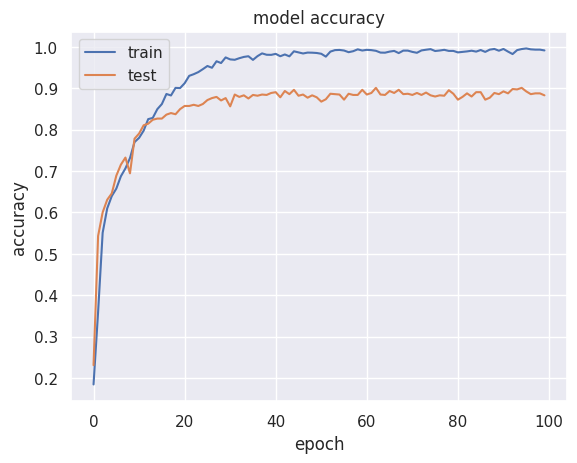

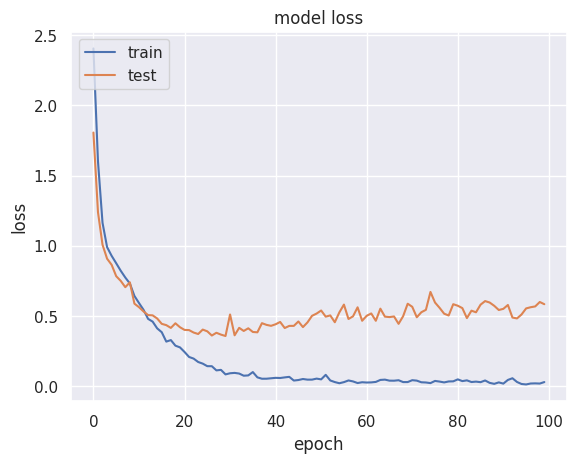

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Comparando Dados

In [ ]:
predictions = model.predict(X_test, batch_size=32)
predictions = predictions.argmax(axis=1)
predictions

33/33 [==============================] - 0s 6ms/step


array([4, 2, 7, ..., 7, 1, 6])

In [ ]:
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})

In [ ]:
predictions

,Classes Previstas
0,neutra
1,medo
2,triste
3,triste
4,calma
...,...
1046,nervosa
1047,feliz
1048,triste
1049,feliz


In [ ]:
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (labelencoder.inverse_transform((actual)))
actual = pd.DataFrame({'Classes Reais': actual})

In [ ]:
finaldf = actual.join(predictions)
finaldf[140:150]

,Classes Reais,Classes Previstas
140,neutra,neutra
141,neutra,neutra
142,medo,surpreso
143,medo,neutra
144,triste,triste
145,nervosa,triste
146,neutra,neutra
147,feliz,feliz
148,triste,triste
149,feliz,feliz


### Matriz de confusão

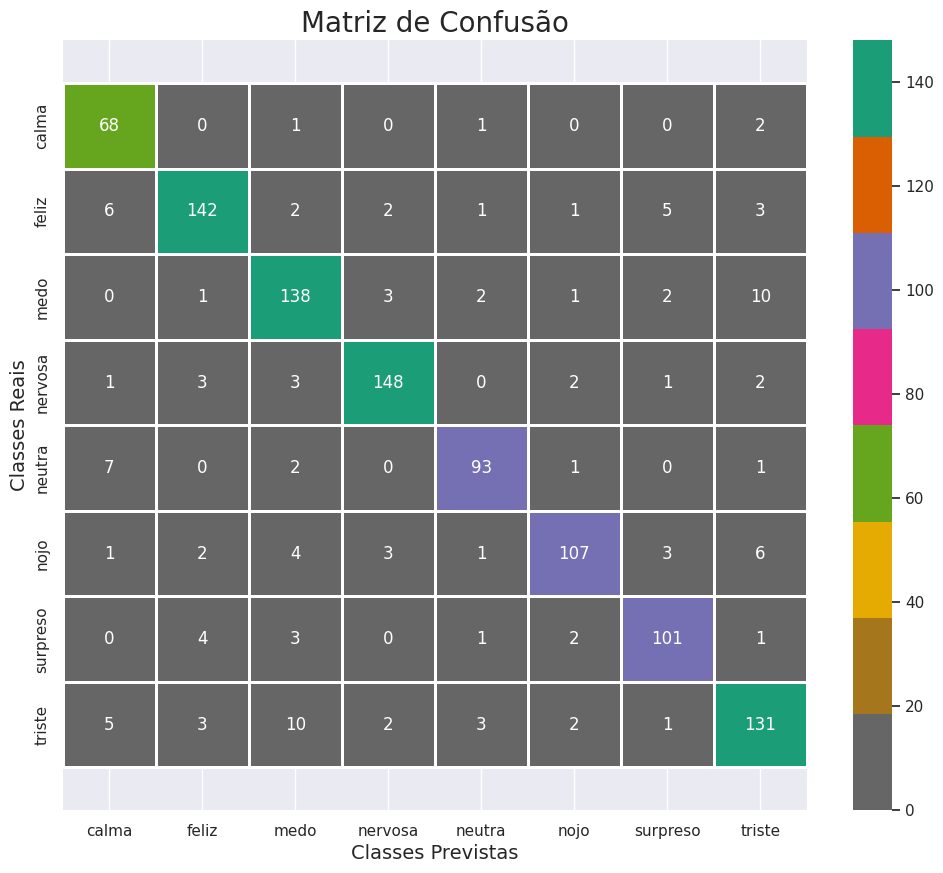

In [ ]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

### Precisão


In [ ]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       calma       0.77      0.94      0.85        72
       feliz       0.92      0.88      0.90       162
        medo       0.85      0.88      0.86       157
     nervosa       0.94      0.93      0.93       160
      neutra       0.91      0.89      0.90       104
        nojo       0.92      0.84      0.88       127
    surpreso       0.89      0.90      0.90       112
      triste       0.84      0.83      0.84       157

    accuracy                           0.88      1051
   macro avg       0.88      0.89      0.88      1051
weighted avg       0.89      0.88      0.88      1051



# Testando o modelo em arquivos de áudio

In [ ]:
def getInfo(data, sample_rate):
  print('Canais:',  data.shape)
  print('Número total de amostras: ', data.shape[0])
  print('Taxa de amostragem: ', sample_rate)
  print('Duração:',  len(data) / sample_rate)

def predictSound(audio_convert, info = False, plot_waveform = False, plot_spectrogram = False):
  audio, sample_rate = librosa.load(audio_convert, sr = 22050, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]
  predictions = model.predict(mfccs_scaled_features, batch_size=32)
  predictions = predictions.argmax(axis=1)
  predictions = predictions.astype(int).flatten()
  predictions = (labelencoder.inverse_transform((predictions)))
  print('Resultado: ', predictions)

  if info:
    getInfo(audio, sample_rate)

  if plot_waveform:
    plt.figure(figsize=(14,5))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    plt.xlabel("Tempo (segundos) ==>")
    plt.ylabel("Amplitude")
    ld.waveplot(audio, sr=sample_rate)

  if plot_spectrogram:
    plt.figure(figsize=(14,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs_features))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    ld.specshow(mfccs_db, x_axis="time", y_axis='log', cmap = 'Spectral')
    plt.colorbar(format='%+2.f dB')

# **Funçao de Chamada**

In [ ]:
r = sr.Recognizer()

def convert(audio_test):

  if audio_test[-3:] == "ogg":
    oggs = []
    path = os.path.dirname('/content/')
    abspath = os.path.abspath(path)
    dirs = os.listdir(abspath)
    song = AudioSegment.from_ogg(audio_test)
    export_name = os.path.splitext(audio_test)[0]
    audio_convert = song.export(export_name + '.wav', format = 'wav')
    r = sr.Recognizer()
    audio = sr.AudioFile(audio_convert)
    audio_predict = audio_test.replace("wav","mp3")
    with audio as source:
      texto = r.record(source)
    return predictSound(audio_predict) or r.recognize_google(texto, language='pt-BR')

  elif audio_test[-3:] == "mp3":
    data1, sample_rate1 = librosa.load(audio_test, sr = None )
    sf.write(audio_test.replace("mp3","wav"), data1, sample_rate1)
    audio_convert = audio_test.replace("mp3","wav")
    r = sr.Recognizer()
    audio = sr.AudioFile(audio_convert)
    audio_predict = audio_test.replace("wav","mp3")
    with audio as source:
      texto = r.record(source)
    return predictSound(audio_predict) or r.recognize_google(texto, language='pt-BR')

  else:
    audio_convert = audio_test.replace("mp3","wav")
    r = sr.Recognizer()
    audio = sr.AudioFile(audio_convert)
    audio_predict = audio_test.replace("wav","mp3")
    with audio as source:
      texto = r.record(source)
    return predictSound(audio_predict) or r.recognize_google(texto, language='pt-BR')

# Teste

In [354]:
audio_test ='/content/Jarvan IV_ _Hoje é um bom dia para morrer._.mp3'
convert(audio_test)

1/1 [==============================] - 0s 77ms/step
Resultado:  ['calma']


'hoje é Um Bom Dia Para Morrer'

In [ ]:
data, sample_rate = librosa.load(audio_test, sr = 22050)
Audio(data = data, rate = sample_rate )